## Notebook to analyze video from Evan Ludes with possible pulsating aurora and ground based sound connection

written by Riley Troyer Fall 2021

In [1]:
# Import libraries
import cv2
from matplotlib import animation
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import math
import numpy as np
import os
from scipy.signal import savgol_filter
from skimage import io, exposure
from skimage.restoration import denoise_nl_means, estimate_sigma
import moviepy.editor as mp
import wave

In [2]:
# Where is the data stored
data_dir = '../data/evan-ludes-aurora-videos/'
filename = 'MVI_1458.MOV'

## First step will be to take a look at one of the frames and see what we are working with

In [3]:
def read_grayscale_frame(video, frame):
    """
    Function to read a frame from a opencv VideoCapture object
    INPUT
    vid_file
        type: OpenCV VideoCapture
        description: The object defining the video the frame is in
    frame
        type: int
        description: The frame number to get
    """
    # Read frame
    video.set(1, frame)
    ret, img = video.read()
    
    # Convert to grayscale assuming frames are in rgb
    gs_img = (img[:, :, 0]*0.2989 
              + img[:, :, 1]*0.5870 
              + img[:, :, 2]*0.1140)
    
    return gs_img

In [4]:
# Read in video and audio
video = cv2.VideoCapture(data_dir + filename)
audio_array = mp.VideoFileClip(data_dir 
                               + filename).audio.to_soundarray()[:, 0]

# And some useful metadata
total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
fps = video.get(cv2.CAP_PROP_FPS)
total_time = total_frames/fps

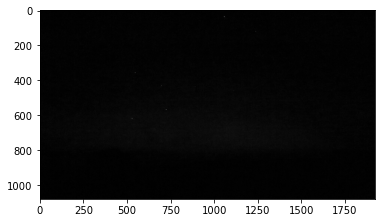

In [5]:
# Plot a frame
frame = 0
gs_img = read_grayscale_frame(video, frame)
plt.imshow(gs_img, cmap='gray')

In [6]:
def average_frames(video, start_frame, length):
    """Function to average a number of frames together"""
    
    # Which frames to average
    frames = np.arange(0, length) + start_frame
    
    # Initialize array to sum all frames
    avg_img = read_grayscale_frame(video, start_frame)
    
    # Loop through and add frames to summed array
    for frame in frames[1:]:
        avg_img = avg_img + read_grayscale_frame(video, frame)
        
    # Get average by dividing by length
    avg_img = avg_img/length
    
    return avg_img

In [7]:
# Try averaging several frames
avg_img = average_frames(video, 0, 5)

# Try boosting contrast
low = 0.1
high = 99.8

v_min, v_max = np.percentile(avg_img, (low, high))

avg_contrast_img = exposure.rescale_intensity(avg_img, 
                                   in_range=(v_min, v_max))

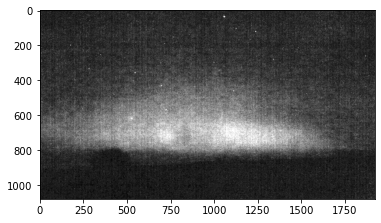

In [8]:
plt.imshow(avg_contrast_img, cmap='gray')

In [9]:
def process_img(frame):
    """Function to process image for animation"""
    
    # Only take every 5 frames as starting frame
    frame = frame + frame*4
    
    # Get the averaged image
    avg_img = average_frames(video, frame, 5)
    
    # Boost the contrast
    low = 0.1
    high = 99.8
    v_min, v_max = np.percentile(average_frames(video, 0, 5),
                                 (low, high))
    avg_img = exposure.rescale_intensity(avg_img, in_range=(v_min, v_max))
    
    return avg_img

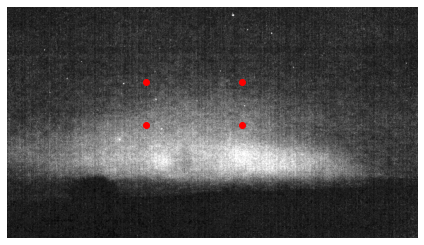

In [10]:
# Create a video with the averaging and contrast boost

# Which start frames to use, will average between these

start_frames = np.arange(0, total_frames)[0::5]

# CREATE MOVIE
img_num = len(start_frames) - 1
fps = 6.0


# Construct an animation
# Setup the figure
fig, axpic = plt.subplots(1, 1)

# No axis for images
axpic.axis('off')

# Plot the image
img = axpic.imshow(process_img(0),
                   cmap='gray', animated=True)

axpic.scatter(1100, 550, color='red')
axpic.scatter(1100, 350, color='red')
axpic.scatter(650, 550, color='red')
axpic.scatter(650, 350, color='red')

# axpic.scatter(1400, 600, color='red')
# axpic.scatter(1400, 800, color='red')
# axpic.scatter(900, 600, color='red')
# axpic.scatter(900, 800, color='red')

plt.tight_layout()

# def updatefig(frame):
#     """Function to update the animation"""

#     # Set new image data
#     img.set_data(process_img(frame))

#     return [img]

# # Construct the animation
# anim = animation.FuncAnimation(fig, updatefig,
#                                frames=img_num,
#                                interval=int(1000.0/fps),
#                                blit=True)

# # Close the figure
# plt.close(fig)


# # Use ffmpeg writer to save animation
# event_movie_fn = ('../data/avg-contrast-1458.mp4')
# writer = animation.writers['ffmpeg'](fps=fps)
# anim.save(event_movie_fn,
#           writer=writer, dpi=150)

In [11]:
# Plot average of pixel box for each frame
total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
avg_intensity = np.zeros(total_frames)
avg_intensity_2 = np.zeros(total_frames)

for frame in np.arange(0, total_frames):
    
    # Read in the image
    img = read_grayscale_frame(video, frame)
    
    # Get average for pixel box
    avg_intensity[frame] = np.mean(img)#np.mean(img[350:550, 650:1100])
    avg_intensity_2[frame] = np.mean(img[600:800, 900:1400])

In [329]:
# # Calculate the rolling average of the event
# N = 30
# avg_intensity_smoothed = np.convolve(avg_intensity, np.ones((N,)) / N,
#                                    mode='valid')
# frames = np.arange(0, total_frames)
# frames_smoothed = frames[math.floor(N / 2):-math.floor(N / 2)]

# plt.plot(avg_intensity_smoothed)

In [18]:
# Calculate the rolling average of the event
avg_intensity_smoothed = savgol_filter(avg_intensity, 51, 3)

# # Shift so average is zero
# avg_intensity_smoothed = (avg_intensity_smoothed 
#                           - np.mean(avg_intensity_smoothed))

# # Normalize so max is 1
# avg_intensity_smoothed = (avg_intensity_smoothed
#                           /np.max(avg_intensity_smoothed))

# Normalize audio so max is also 1
audio_array = audio_array/np.max(audio_array)

NameError: name 'avg_intensity_smoothed_2' is not defined

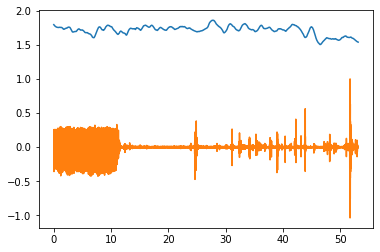

In [13]:
# Plot average along with audio
audio_x = np.linspace(0, total_time, len(audio_array))
video_x = np.linspace(0, total_time, len(avg_intensity_smoothed))

plt.plot(audio_x, audio_array, color='C1')
plt.plot(video_x, avg_intensity_smoothed, color='C0')
plt.plot(video_x, avg_intensity_smoothed_2, color='C2')

plt.xlim(12, 50)

## Perform a Fourier transform on the sound data

In [12]:
# Create FFT for specified capture
start_time = 0
waveform = audio_array

# Create indices to create ffts for
fft_window = int(1024*4)

# Indices
indices = np.arange(0, len(waveform), 1)

# Window step
step = int(fft_window/2)

# Remove step length from end of indices
indices = indices[0:-fft_window]

# Loop through every step amount
indices = indices[0::step]

# Create array to store FFT
psd = np.zeros([fft_window, len(indices)])
for n, i in enumerate(indices):
    # Perform the fft
    data = waveform[i : i+fft_window]
    fft = np.fft.fft(data)
    #...then write to array and get psd
    psd[:, n] = np.real(fft*np.conj(fft))
    
# Filter to psd range
psd_min = 1e-2
psd_max = 1e-1
psd[psd < psd_min] = psd_min
psd[psd > psd_max] = psd_max

# Create meshgrids for time and frequency
#...time coverage is 6 seconds
#...to make range first convert to timestamp
burst_times = np.linspace(0, total_time, len(indices))
tstep = total_time/len(indices)

# Frequency
burst_freq = np.linspace(0, fft_window, fft_window)/tstep

# Turn into meshgrids
burst_time_mesh, burst_freq_mesh = np.meshgrid(burst_times,
                                               burst_freq)

In [33]:
burst_times.shape

(1142,)

In [34]:
burst_freq.shape

(4096,)

In [30]:
psd[0:2000, 0:500].shape

(2000, 500)

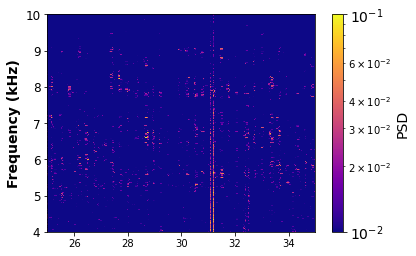

In [50]:
# Plot the psd spectrum
fig, ax = plt.subplots()
psd_plot = ax.pcolormesh(burst_time_mesh, burst_freq_mesh/1000,
                         psd,
                         norm=mcolors.LogNorm(),
                         cmap='plasma', shading='auto')

# Create colorbar
psd_cbar = fig.colorbar(psd_plot, ax=ax)
psd_cbar.set_label(r'PSD', fontsize=14)
psd_cbar.ax.tick_params(labelsize=14)

# Setup axes
ax.set_ylabel('Frequency (kHz)', fontsize=14, fontweight='bold')

#ax.set_xlim(start_time, end_time)
ax.set_ylim(4, 10)
#ax.set_yscale('log')
ax.set_xlim(25, 35)


ax.tick_params(axis='y', which='major', labelsize=12)

In [ ]:
# Function to calculate a running geometric mean

In [51]:
# Get the slice of data corresponding to frequencies
psd_slice = psd[(burst_freq >= 5000) & (burst_freq<=9000),
                  :]

# Average over frequencies
psd_slice = np.mean(psd_slice, axis=0)

# Any signal > specified value is set to average of values around it
spikes = np.where(psd_slice > 0.075)[0]

no_spikes = np.where(psd_slice <= 0.075)[0]

# Loop through each spike
for spike in spikes:
    
    # Find the 5 closest values
    diff = abs(no_spikes - spike)
    avg_points = no_spikes[np.argpartition(diff, 5)[0:5]]
    
    psd_slice[spike] = np.mean(psd_slice[avg_points])

# Calculate the rolling average of the event
N = 51
psd_smoothed = np.convolve(psd_slice, np.ones((N,)) / N,
                                   mode='valid')

psd_x_smoothed = burst_times[math.floor(N / 2):-math.floor(N / 2)]

# Exclude start and end times
psd_smoothed = psd_smoothed[(psd_x_smoothed > 12) 
                            & (psd_x_smoothed < 50)]
psd_x_smoothed = psd_x_smoothed[(psd_x_smoothed > 12) 
                                & (psd_x_smoothed < 50)]

# # Shift so average is zero
# psd_smoothed = (psd_smoothed - np.mean(psd_smoothed))

# # Normalize psd so max is also 1
# psd_smoothed = psd_smoothed/np.max(psd_smoothed)

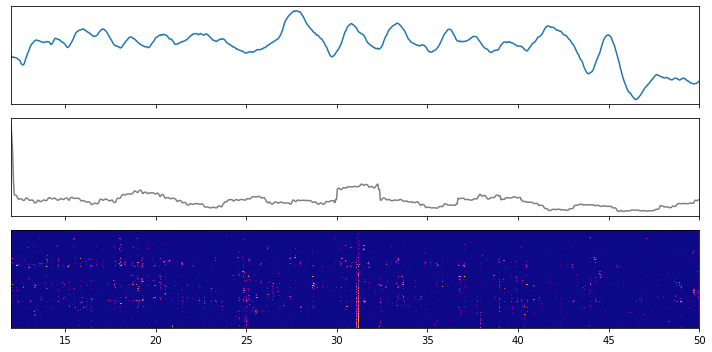

In [52]:
fig, axs = plt.subplots(3, 1, sharex=True,
                        figsize=(10,5))

# Plot average along with audio psd
audio_x = psd_x_smoothed
video_x = np.linspace(0, total_time, len(avg_intensity_smoothed))

axs[0].plot(video_x, avg_intensity_smoothed, color='C0')
axs[1].plot(audio_x, psd_smoothed, color='gray')

axs[1].vlines(burst_times[spikes], np.min(psd_smoothed),
           np.max(psd_smoothed), color='red')

axs[2].pcolormesh(burst_time_mesh, burst_freq_mesh/1000,
                         psd,
                         norm=mcolors.LogNorm(),
                         cmap='plasma', shading='auto')

# Setup axes
axs[2].set_ylabel('kHz')

#ax.set_xlim(start_time, end_time)
axs[2].set_ylim(4, 10)

# Turn off y axis
axs[0].yaxis.set_visible(False)
axs[1].yaxis.set_visible(False)
axs[2].yaxis.set_visible(False)

plt.xlim(12, 50)
#plt.ylim(-0.5, 1.25)

plt.tight_layout()

plt.savefig('../possible-correlation.jpg', dpi=200)